In [1]:
from factor_analysis import *

|指数代码|指数简称|指数全称|
|-|-|-|
|CI005001.INDX|中信-石油石化|中信证券-石油石化|
|CI005002.INDX|中信-煤炭|中信证券-煤炭|
|CI005003.INDX|中信-有色金属|中信证券-有色金属|
|CI005004.INDX|中信-电力及公用事业|中信证券-电力及公用事业|
|CI005005.INDX|中信-钢铁|中信证券-钢铁|
|CI005006.INDX|中信-基础化工|中信证券-基础化工|
|CI005007.INDX|中信-建筑|中信证券-建筑|
|CI005008.INDX|中信-建材|中信证券-建材|
|CI005009.INDX|中信-轻工制造|中信证券-轻工制造|
|CI005010.INDX|中信-机械|中信证券-机械|
|CI005011.INDX|中信-电力设备及新能源|中信证券-电力设备及新能源|
|CI005012.INDX|中信-国防军工|中信证券-国防军工|
|CI005013.INDX|中信-汽车|中信证券-汽车|
|CI005014.INDX|中信-商贸零售|中信证券-商贸零售|
|CI005015.INDX|中信-消费者服务|中信证券-消费者服务|
|CI005016.INDX|中信-家电|中信证券-家电|
|CI005017.INDX|中信-纺织服装|中信证券-纺织服装|
|CI005018.INDX|中信-医药|中信证券-医药|
|CI005019.INDX|中信-食品饮料|中信证券-食品饮料|
|CI005020.INDX|中信-农林牧渔|中信证券-农林牧渔|
|CI005021.INDX|中信-银行|中信证券-银行|
|CI005022.INDX|中信-非银行金融|中信证券-非银行金融|
|CI005023.INDX|中信-房地产|中信证券-房地产|
|CI005024.INDX|中信-交通运输|中信证券-交通运输|
|CI005025.INDX|中信-电子|中信证券-电子|
|CI005026.INDX|中信-通信|中信证券-通信|
|CI005027.INDX|中信-计算机|中信证券-计算机|
|CI005028.INDX|中信-传媒|中信证券-传媒|
|CI005029.INDX|中信-综合|中信证券-综合|
|CI005030.INDX|中信-综合金融|中信证券-综合金融|


<img src="行业分类.png" alt="drawing" width="1000"/> 

In [2]:
def get_industry_exposure(order_book_ids,datetime_period):
    
    """
    :param order_book_ids: 股票池 -> list
    :param datetime_period: 研究日 -> list
    :return result: 虚拟变量 -> dataframe
    """
    
    zx2019_industry = rqdatac.client.get_client().execute('__internal__zx2019_industry')
    df = pd.DataFrame(zx2019_industry)
    df.set_index(['order_book_id', 'start_date'], inplace=True)
    df = df['first_industry_name'].sort_index()
    print('中信行业数据已获取')

    #构建动态行业数据表格
    index = pd.MultiIndex.from_product([order_book_ids, datetime_period], names=['order_book_id', 'datetime'])
    pos = df.index.searchsorted(index, side='right') - 1
    index = index.swaplevel()   # level change (oid, datetime) --> (datetime, oid)
    result = pd.Series(df.values[pos], index=index)
    result = result.sort_index()
    print('动态行业数据已构建')
    
    #生成行业虚拟变量
    return result


# IC计算 
def Factor_Return_N_IC(df,n,name = '',Rank_IC = True,industry_group = True):

    """
    :param df: 因子值 -> unstack
    :param n: 调仓日 -> int
    :param Rank_IC: TrueRank_ic FalseNormal_ic -> bool
    :param industry_group: True行业聚类 False所有行业 -> bool
    :return x: IC序列 -> dataframe
    :return half_life:半衰期 -> dataframe
    :return industry_ic_analyse: 中信行业ic检验值 -> dataframe
    """

    order_book_ids = df.columns.tolist()
    datetime_period = df.index.tolist()
    start = datetime_period[0].strftime('%Y-%m-%d')
    end = datetime_period[-1].strftime('%Y-%m-%d')
    try:
        close = pd.read_pickle(f'close_{start}_{end}.pkl')
    except:
        close = get_price(order_book_ids, start_date=start, end_date=end,frequency='1d',fields='close').close.unstack('order_book_id')
        close.to_pickle(f'close_{start}_{end}.pkl')
    
    return_n = close.pct_change(n).shift(-n)

    if Rank_IC == True:
        x = df.corrwith(return_n,axis = 1,method='spearman').dropna(how = 'all')
    else:
        x = df.corrwith(return_n,axis = 1,method='pearson').dropna(how = 'all')
    
    # 半衰期
    half_life = {}
    print('loading half_life ... ')
    for i in tqdm(range(1,21)):
        half_life[i] = df.corrwith(close.pct_change().shift(-i),axis = 1,method='spearman').dropna(how = 'all').mean()

    half_life = pd.DataFrame(half_life.items())
    half_life.columns = ['day','ic']
    half_life.set_index(['day'],inplace = True)

    #half_life.plot(kind = 'bar',title = f'{name}_halflife')
    plt.figure(figsize=(18,10))
    plt.subplot(2, 2, 1)
    plt.bar(half_life.index,half_life.ic)
    plt.title(f'{name}_half_life')

    # 逐季度ic
    plt.subplot(2, 2, 2)
    month_ic = (x.resample('M').mean()/x.resample('M').std()).to_frame('m_ic')
    plt.bar(month_ic.index,month_ic.m_ic,width = 30)
    plt.title(f'{name}_ir_3m')

    t_stat, p_value = stats.ttest_1samp(x, 0)
    
    print(['IC mean:{}'.format(round(x.mean(),4)),
            'IC std:{}'.format(round(x.std(),4)),
            'IR:{}'.format(round(x.mean()/x.std(),4)),
            'IR_LAST_1Y:{}'.format(round(x[-240:].mean()/x[-240:].std(),4)),
            'IC>0:{}'.format(round(len(x[x>0].dropna())/len(x),4)),
            'ABS_IC>2%:{}'.format(round(len(x[abs(x) > 0.02].dropna())/len(x),4)),
            't_stat:{}'.format(t_stat.round(4))
           ]) 
    
    # 累计ic
    plt.subplot(2, 2, 4)
    plt.plot(x.cumsum())
    plt.title(f'{name}_cumic')
    #x.cumsum().plot(title = f'{name}_cumic')

    industry_group_name = {'finance':['银行','非银行金融','综合金融'],
                        'special_consumption' : ['汽车','家电','食品饮料','餐饮旅游'],
                        'normal_consumption' : ['农林牧渔','纺织服装','医药','商贸零售','消费者服务','轻工制造'],
                        'technology' : ['电子','通信','计算机','传媒'],
                        'up_cycle' : ['石油石化','煤炭','有色金属'],
                        'mid-cycle' : ['基础化工','钢铁','建材','机械','电力设备及新能源','国防军工','电力设备', '电子元器件'],
                        'down-cycle' : ['建筑','房地产','电力及公用事业','交通运输'],
                        }
    try:
        industry = pd.read_pickle(f'industry_{start}_{end}.pkl')
    except:
        industry = get_industry_exposure(order_book_ids,datetime_period).unstack()
        industry.to_pickle(f'industry_{start}_{end}.pkl')

    if industry_group == True:
        # 聚类分组后行业
        industry_ic_analyse = {}
        for i in list(industry_group_name.keys()):
            for j in industry_group_name[i]:
                industry.replace(j,i,inplace = True)
        for i in tqdm(list(industry_group_name.keys())):
            industry_group_ic = close.mask(industry[industry == i].isnull()).corrwith(df,axis = 1,method='spearman').dropna(how = 'all')
            industry_ic_analyse[i] = [industry_group_ic.mean(),industry_group_ic.mean()/industry_group_ic.std()]

        industry_ic_analyse = pd.DataFrame(industry_ic_analyse).T
        industry_ic_analyse.columns = ['IC','IR']
        # 行业IC/IR
        plt.subplot(2, 2, 3)
        plt.bar(industry_ic_analyse.index,industry_ic_analyse.IC)
        plt.xticks(rotation=90)
        plt.title(f'{name}_citics_industry_group_ic')

    else:
        # 各行业表现
        industry_name = list(set(industry.stack()))
        industry_ic_analyse = {}
        print('loading industry ... ')
        for i in tqdm(industry_name):
            industry_ic = close.mask(industry[industry == i].isnull()).corrwith(df,axis = 1,method='spearman').dropna(how = 'all')
            industry_ic_analyse[i] = [industry_ic.mean(),industry_ic.mean()/industry_ic.std()]
            #print(i,'IC',round(industry_ic.mean(),4),'IR',round(industry_ic.mean()/industry_ic.std(),4))

        industry_ic_analyse = pd.DataFrame(industry_ic_analyse).T
        industry_ic_analyse.columns = ['IC','IR']
        # 行业IC/IR
        plt.subplot(2, 2, 3)
        plt.bar(industry_ic_analyse.index,industry_ic_analyse.IC)
        plt.xticks(rotation=90)
        plt.title(f'{name}_citics_industry_ic')

    plt.suptitle(f'{name}_ic_analyse')
    plt.show()
    
    return x,half_life,industry_ic_analyse


In [12]:
start_date = '2020-01-01'
end_date = '2023-06-01'

#### 聚类

In [4]:
index_code = ['CI005001.INDX','CI005002.INDX','CI005003.INDX','CI005004.INDX','CI005005.INDX','CI005006.INDX','CI005007.INDX','CI005008.INDX','CI005009.INDX','CI005010.INDX',
              'CI005011.INDX','CI005012.INDX','CI005013.INDX','CI005014.INDX','CI005015.INDX','CI005016.INDX','CI005017.INDX','CI005018.INDX','CI005019.INDX','CI005020.INDX',
              'CI005021.INDX','CI005022.INDX','CI005023.INDX','CI005024.INDX','CI005025.INDX','CI005026.INDX','CI005027.INDX','CI005028.INDX','CI005029.INDX','CI005030.INDX',
              ]
close = get_price(index_code,start_date,end_date,fields = 'close').close.unstack('order_book_id')
close = close/close.iloc[0]

In [5]:
industry_return = close.pct_change().dropna(how = 'all')

In [7]:
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [8]:
data = industry_return.T

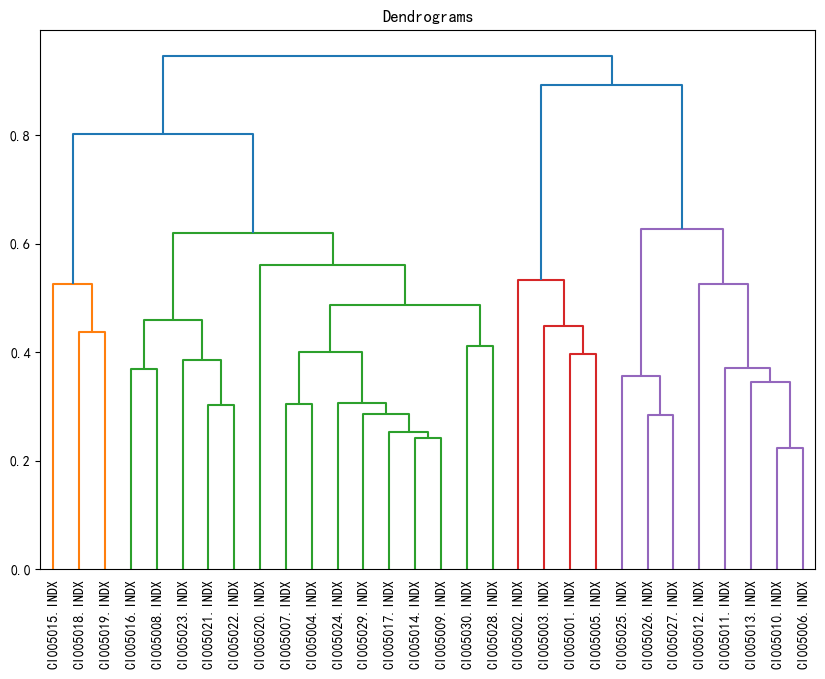

In [9]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(data, method='ward',metric='euclidean')
                      ,labels = data.index #orientation='left' #横向或者纵向呈现
                      ,leaf_rotation=90 #标签文字是否旋转
                      ,leaf_font_size=10 #标签文字大小
                      )
plt.hlines(y=4,xmin=0,xmax=1000,linestyles='--')

####  行业IC计算

In [13]:
index_fix = index_fix(start_date,end_date,'000906.XSHG')
# 获取日期 和 标的
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

In [17]:
# 获取日期 和 标的
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

new_stock_filter = get_new_stock_filter(stock_list,date_list)
st_filter = get_st_filter(stock_list,date_list)
suspended_filter = get_suspended_filter(stock_list,date_list)
limit_up_down_filter = get_limit_up_down_filter(stock_list,date_list).fillna(True)

def data_clean(factor,new_stock_filter = new_stock_filter,st_filter = st_filter,suspended_filter = suspended_filter,limit_up_down_filter = limit_up_down_filter,index_fix= index_fix):
    # 剔除ST、涨停、停牌、新股、动态券池
    factor = factor.mask(new_stock_filter).mask(st_filter).mask(suspended_filter).mask(limit_up_down_filter).mask(~index_fix).dropna(how = 'all')
    print('券池过滤完毕')
    # 离群值处理
    factor = factor.apply(lambda x :filter_extreme_MAD(x,3), axis=1)
    # 标准化
    factor = factor.sub(factor.mean(axis=1), axis=0).div(factor.std(axis=1), axis=0) #add
    print('因子数据清洗完成，已剔除离群值、中性化处理')
    # 行业市值中性化
    factor = neutralization(factor)
    print('因子完成行业市值中性化')
    
    return factor

new_stock_filter load
st_filter load
suspended_filter load
limit_up_down_filter load


In [15]:
dp = Factor('dividend_yield_ttm')
dp = execute_factor(dp,stock_list,start_date,end_date)

In [19]:
df_neu = data_clean(dp)

券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
中信行业数据已获取
动态行业数据已构建


100%|██████████| 827/827 [00:10<00:00, 80.35it/s] 


因子完成行业市值中性化


loading half_life ... 


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


['IC mean:0.0392', 'IC std:0.1064', 'IR:0.3686', 'IR_LAST_1Y:0.5394', 'IC>0:0.5799', 'ABS_IC>2%:0.8773', 't_stat:10.4715']


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


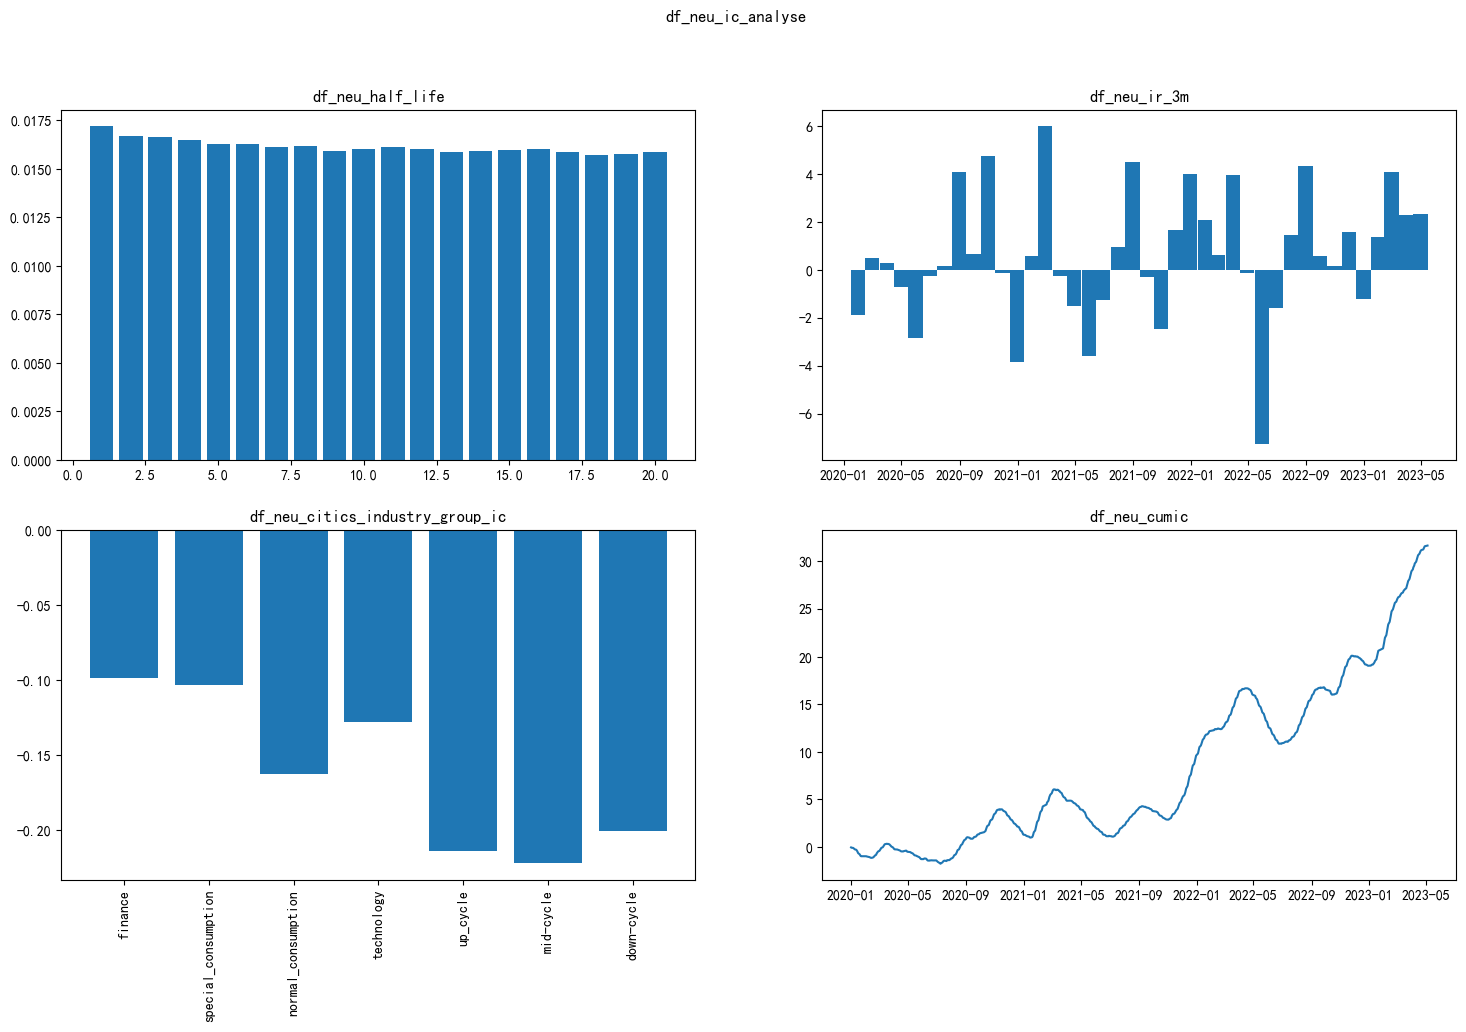

In [21]:
x,half_life,industry_ic_analyse = Factor_Return_N_IC(df_neu,20,name = 'df_neu')

loading half_life ... 


100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


['IC mean:0.0392', 'IC std:0.1064', 'IR:0.3686', 'IR_LAST_1Y:0.5394', 'IC>0:0.5799', 'ABS_IC>2%:0.8773', 't_stat:10.4715']
loading industry ... 


100%|██████████| 30/30 [00:19<00:00,  1.57it/s]


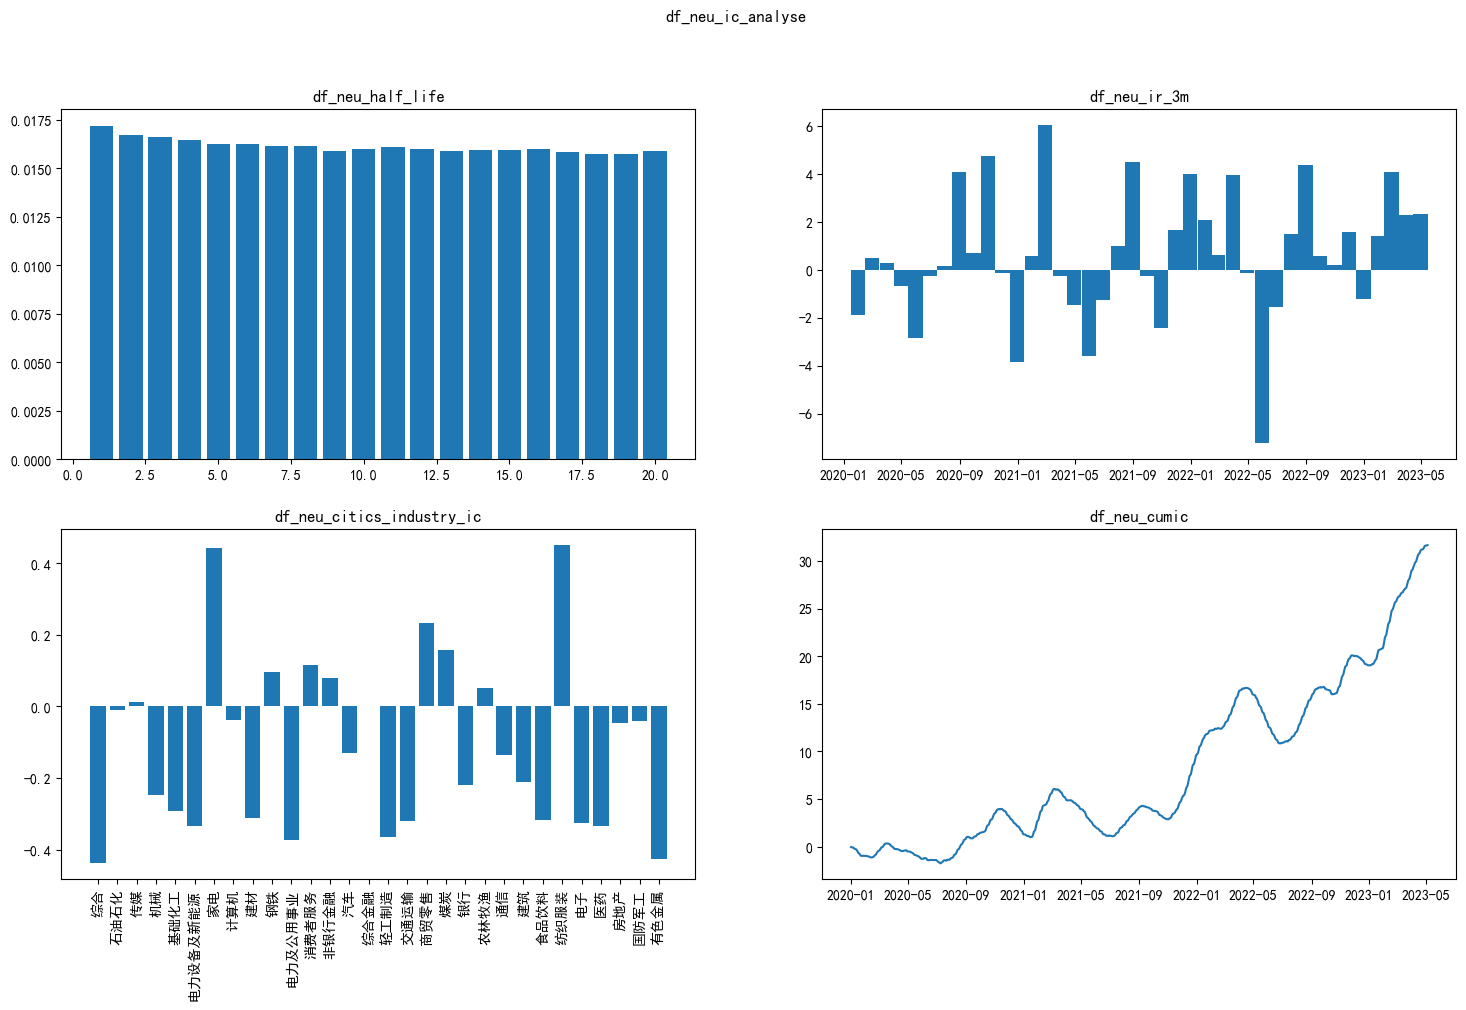

In [22]:
x,half_life,industry_ic_analyse = Factor_Return_N_IC(df_neu,20,name = 'df_neu',industry_group=False)